# **Translation of an Abstract or Title to Portuguese**

Advanced Topics in Machine Learning - Group P1_C

Produced by:
- Catarina Monteiro up202105279
- Diogo Mendes up202108102
- Gonçalo Brochado up202106090

This approach aims to translate the abstracts and titles of scientific papers to enhance accessibility for portuguese non-English speakers. By providing translations, we seek to break down language barriers and ensure that valuable research findings are available to a broader audience.

## **Dependencies**

In [ ]:
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install deep-translator

## **Libraries**

In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import sacrebleu
import torch
from transformers import MarianMTModel, MarianTokenizer

## **Data**

The data for the project was retrieved using the Hugging Face datasets library, specifically loading the Arxiv abstracts dataset. This dataset includes metadata from scientific papers, such as titles, abstracts, author names, and categories, and provides a comprehensive base for training and evaluating models for title generation, abstract generation, and category prediction.

In [6]:
ds = load_dataset("gfissore/arxiv-abstracts-2021")

README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

arxiv-abstracts.jsonl.gz:   0%|          | 0.00/940M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999486 [00:00<?, ? examples/s]

In [7]:
ds['train'].column_names

['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'abstract',
 'report-no',
 'categories',
 'versions']

In [ ]:
# Limit the first 100 samples for test
abstracts = ds['train']['abstract'][:100]
titles = ds['train']['title'][:100]

In [ ]:
def translate(titles, abstracts):
    title_translate = []
    abs_translate = []

    for title, abstract in zip(titles, abstracts):
        # Translate title
        translated_title = GoogleTranslator(source='en', target='pt').translate(title)
        title_translate.append(translated_title)

        # Translate abstract
        translated_abs = GoogleTranslator(source='en', target='pt').translate(abstract)
        abs_translate.append(translated_abs)

    return title_translate, abs_translate


In [15]:
title_translate, abs_translate = translate(titles, abstracts)

In [17]:
print(len(title_translate))

100


## **Test Models**

This code defines functions for evaluating the quality of translations generated from English to Portuguese. It employs three key metrics: **ROUGE**, **BLEU**, and **METEOR** to assess the similarity between the generated translations and the reference translations in the base dataset. The `teste_model` function utilizes a tokenizer and model to process the input texts, generating translations while collecting the results for evaluation. In contrast, the `teste_model2` function leverages a translation pipeline for the same purpose. Both functions return the computed scores and the generated translations, providing a comprehensive assessment of the translation quality.

In [ ]:
def rouge_scores(generated_translate, base): #ROUGE
  rouge = evaluate.load('rouge')
  results = rouge.compute(predictions=generated_translate, references=base)
  return results

def blue_score(generated_translate,base): #BLUE
  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=generated_translate, references=[[text] for text in base])
  return results

def meteor_score(generated_translate, base):  # METEOR
  meteor = evaluate.load("meteor")
  results = meteor.compute(predictions=generated_translate, references=base)
  return results

def teste_model(texts, base, tokenizer, model): #Test Model
  generated_translations = []

  for text in texts:
    src_text = f">>por<< {text}"
    inputs = tokenizer(src_text, return_tensors="pt", padding=True).to(device)
    translated = model.generate(**inputs)
    r = tokenizer.decode(translated[0], skip_special_tokens=True)
    generated_translations.append(r)
    print(r)

  rouge = rouge_scores(generated_translations, base)
  blue = blue_score(generated_translations, base)
  meteor = meteor_score(generated_translations, base)

  return rouge , blue, meteor, generated_translations

def teste_model2(texts, base, tokenizer, model): #Test Model
  generated_translations = []

  for text in texts:

    translated = enpt_pipeline(f"translate English to Portuguese: {text}")

    generated_translations.append(translated[0]['generated_text'])
    print(translated[0]['generated_text'])

  rouge = rouge_scores(generated_translations, base)
  blue = blue_score(generated_translations, base)
  meteor = meteor_score(generated_translations, base)

  return rouge , blue, meteor, generated_translations

For this evaluation, we will use translations made by Google Translate as a basis for comparison.

### Opus-mt-tc-big-en-pt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model and tokenizer
model_name = "Helsinki-NLP/opus-mt-tc-big-en-pt"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(54776, 1024, padding_idx=54775)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(54776, 1024, padding_idx=54775)
      (embed_positions): MarianSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1

In [ ]:
# Title translation
r_o_t, b_o_t, m_o_t, gen_titles_o_t = teste_model(titles, title_translate, tokenizer, model)
print(r_o_t) #ROUGE
print(b_o_t) #BLEU
print(m_o_t) #METEOR

Cálculo de seções transversais de produção de difótons imediatos nas energias Tevatron e LHC
Decomposições gráficas certificantes de sparsity
A evolução do sistema Terra-Lua com base no modelo de fluido de campo de matéria escura
Um determinante dos números do ciclo de Stirling conta os autômatos de fonte única acíclicos não rotulados
De dyadic $Lambda_alpha$ a $Lambda_alpha$
Personagens bosônicos de Cooper atômico em pares através da ressonância
A Mecânica Quântica do Polímero e seu Limite de Continuidade
Solução numérica de compressão de choque e rampa para propriedades gerais do material
O Spitzer c2d Survey de grandes nuvens interestelares próximas. IX. A população de YSO de Serpens como observado com IRAC e MIPS
Cubos parciais: estruturas, caracterizações e construções
Computação gênero 2 Hilbert-Siegel formas modulares sobre $Q(sqrt5)$ através da correspondência Jacquet-Langlands
Distribuição de coeficientes de Fourier integrais de uma forma modular de meio módulo de peso integra

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'rouge1': 0.8221855539763107, 'rouge2': 0.6626969139131186, 'rougeL': 0.7924110977760848, 'rougeLsum': 0.7991307611801918}
{'bleu': 0.5000110350755187, 'precisions': [0.7690265486725664, 0.574757281553398, 0.45698924731182794, 0.38267148014440433], 'brevity_penalty': 0.9482876967974061, 'length_ratio': 0.9495798319327731, 'translation_length': 1130, 'reference_length': 1190}
{'meteor': 0.7725668426861771}


In [ ]:
#Abstract translation
r_o_a, b_o_a, m_o_a,gen_titles_o_a = teste_model(abstracts, abs_translate, tokenizer, model)
print(r_o_a) #ROUGE
print(b_o_a) #BLEU
print(m_o_a) #METEOR

Um cálculo totalmente diferencial em cromodinâmica quântica perturbativa é apresentado para a produção de pares de fótons maciços em colisores de hádrons. Todos os próximos-à-principal ordem diturbativa de dados mostrados contribuições de quark-antiquark, glúon-(anti)quark, e os subprocessos de glúon-glúon são incluídos, bem como todos-ordens a reintegração dos processos de glúon da região inicial.
Descrevemos um novo algoritmo, o jogo de $(k,ell)$-pebble com cores, e o usamos para obter uma caracterização da família de $(k,ell)$-sparse gráficos e soluções algorítmicas para uma família de problemas relacionados a decomposição de grafos de árvores. Exemplos especiais de grafos esparsos aparecem na teoria da rigidez e receberam maior atenção nos últimos anos. Em particular, nossos novos pedrinhas coloridos generalizam e fortalecem os resultados anteriores.
A evolução do sistema Terra-Lua é descrita pelo modelo de fluido de campo de matéria escura proposto na Reunião da Divisão de Partícu

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'rouge1': 0.6554993781942209, 'rouge2': 0.5496173866603203, 'rougeL': 0.6200452760658373, 'rougeLsum': 0.6383829939528877}
{'bleu': 0.24210758032478227, 'precisions': [0.8080568720379147, 0.643975751452387, 0.5492453312867741, 0.48173101839854887], 'brevity_penalty': 0.39745483120341585, 'length_ratio': 0.5201089776855216, 'translation_length': 8018, 'reference_length': 15416}
{'meteor': 0.49916728568405405}


### Unicamp-dl/translation-en-pt-t5


In [32]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

tokenizer = AutoTokenizer.from_pretrained("unicamp-dl/translation-en-pt-t5")
model = AutoModelForSeq2SeqLM.from_pretrained("unicamp-dl/translation-en-pt-t5")
enpt_pipeline = pipeline('text2text-generation', model=model, tokenizer=tokenizer, device = 0)

#enpt_pipeline("translate English to Portuguese: I like to eat rice.")

tokenizer_config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/756k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Eu gosto de comer arroz.'}]

In [ ]:
#Title translation
r_u_t, b_u_t, m_u_t, gen_titles_u_t = teste_model2(titles, title_translate, tokenizer, model)
print(r_u_t) #ROUGE
print(b_u_t) #BLEU
print(m_u_t) #METEOR

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Cálculo das seções transversais de produção rápida de difónios a partir das
Decomposições gráficas comprovativas de esparsidade
Evolução do sistema Terra-Lua com base no modelo de fluido de campo da matéria escura
Um determinante do número do ciclo de rodagem conta os autômatos de origem única acíclicos
De díade $\Lambda_{\alpha}$ a $\
Caracteres bosônicos dos pares atômicos de Cooper em ressonância
Polimer Quantum Mechanics e seu Limite Continuum
Solução numérica de choque e compressão de rampa para propriedades gerais do material


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


O Spitzer c2d Survey of Large, Nearby, Insterstell
Cubos parciais: estruturas, caracterizações e construções
Computação do gênero 2 formas modulares de Hilbert-Siegel sobre $
Distribuição dos Coeficientes de Fourier Integrais de uma Forma Modular de Míni
$p$- Limite ádico de Formas Modulares de Peso Integral Fra
Integral iterado e o produto de alça
Amplitudes das alças de supersoldagem fermiônica no formalismo puro
Vida dos barões duplamente encantados
Observações espectroscópicas da EX Hydrae do Polar Intermediário na Qui
Em busca de um teorema generalizado do índice de Callias
Aproximação da probabilidade de extinção do processo de contacto com base na base Gr\"
Medição do Fator de Forma Hadrônico em D0 -- > K
Eventos de sincronização molecular em feixes de enzimas alostericamente reguladas
Integradores do grupo da Lie
ALMA como a sonda ideal da cromosfera solar
Formação de quasi-solitons em meio de filme ferromagnético confinado transverso
Propriedades espectroscópicas de Polarons e

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Abstract translation
r_u_a, b_u_a, m_u_a, gen_titles_u_a = teste_model2(abstracts, abs_translate, tokenizer, model)
print(r_u_a) #ROUGE
print(b_u_a) #BLEU
print(m_u_a) #METEOR


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


É apresentado um cálculo totalmente diferencial na cromodinâmica quântica perturbativa para a produção de pares de 
Descrevemos um novo algoritmo, o jogo $(k,\ell)$-pe
A evolução do sistema Terra-Lua é descrita pelo modelo do fluido de campo da matéria escura
Mostramos que um determinante do número do ciclo de rodagem conta um autômato de fonte única a
Neste trabalho, mostramos como calcular a norma $\Lambda_{\alpha
Estudamos a função de onda de duas partículas de átomos pareados num gás Fer
Uma representação quântica muito não-padrão das relações de comutação canônica de sistemas de
Foi desenvolvida uma formulação geral para representar modelos materiais para aplicações em carregamento dinâmico. Foram concebidos
Discutemos os resultados das observações combinadas da IRAC e da MIPS c2
Os cubos parciais são subgrafos isométricos de hipercubos. As estruturas de
Neste trabalho apresentamos um algoritmo para calcular os autossistemas de Hecke de formas de
Recentemente, Bruinier e Ono class

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'rouge1': 0.20044542062584433, 'rouge2': 0.14676411945069137, 'rougeL': 0.18956624273123462, 'rougeLsum': 0.19462492598348358}
{'bleu': 2.5376564183521816e-05, 'precisions': [0.8458781362007168, 0.6416988416988417, 0.5213389121338912, 0.4228310502283105], 'brevity_penalty': 4.314706948472811e-05, 'length_ratio': 0.0904903995848469, 'translation_length': 1395, 'reference_length': 15416}
{'meteor': 0.09805573823488038}


## **Results**

### **ROUGE, BLEU e METEOR metrics**

- **Rouge** :
  - **Rouge-1**: Measures the overlap of individual words, ensuring that the translation includes key scientific terms.
  - **Rouge-L**: Measures the longest common sequence of words, which is essential for ensuring the fluency of the translation.
- **Bleu** : Provides an overview of lexical matching but should be considered alongside other metrics for a balanced evaluation.
- **METEOR**: Offers a more semantic assessment, capturing nuances in meaning.

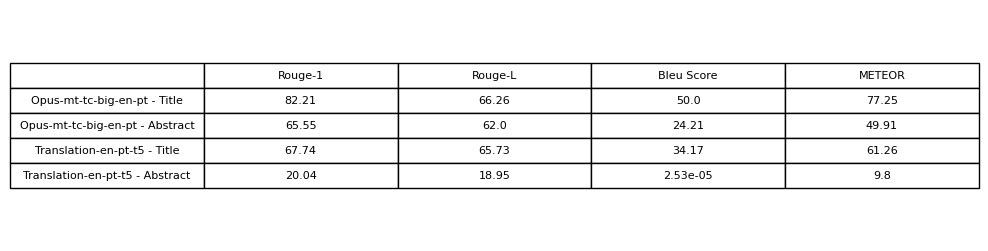

In [ ]:
data = [
    ["", "Rouge-1", "Rouge-L", "Bleu Score", "METEOR"],  
    ["Opus-mt-tc-big-en-pt - Title", 82.21, 66.26, 50.00, 77.25],
    ["Opus-mt-tc-big-en-pt - Abstract", 65.55, 62.00, 24.21, 49.91],
    ["Translation-en-pt-t5 - Title", 67.74, 65.73, 34.17, 61.26],
    ["Translation-en-pt-t5 - Abstract", 20.04, 18.95, 2.53e-05, 9.80]
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2.5, 1.5)

plt.show()

We decided to use these two models and test them for the translation of titles and abstracts. As expected, the results for title generation are better.

As we can see from the results, the model Opus-mt-tc-big-en-pt stands out in both translation tasks (titles and abstracts), achieving the highest scores across all metrics. This indicates that this model is more reliable for producing high-quality translations, and therefore it will be used for this task.